In [1]:
%matplotlib inline

In [2]:
import cPickle
import copy
import h5py
import json
import glob
import os
import numpy as np

from collections import defaultdict, Counter
from matplotlib import pyplot as plt
from nltk.corpus import wordnet as wn
from tqdm import tqdm
from PIL import Image, ImageDraw

/home/hyeonwoonoh/.local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import math

In [83]:
plt.style.use('seaborn')

In [4]:
genome_dir = 'data/preprocessed/visualgenome/memft_all_new_vocab50_obj3000_attr1000_maxlen10'
vqa_dir = 'data/preprocessed/vqa_v2/qa_split_objattr_answer_3div4_genome_memft_check_all_answer_thres1_50000_thres2_-1'
genome_img_dir = 'data/VisualGenome/VG_100K'
vqa_img_dir = 'data/VQA_v2/images'

In [5]:
vqa_anno = cPickle.load(open(os.path.join(vqa_dir, 'merged_annotations.pkl'), 'rb'))

In [6]:
qa_split = cPickle.load(open(os.path.join(vqa_dir, 'qa_split.pkl'), 'rb'))

In [7]:
qa_dict = cPickle.load(open(os.path.join(vqa_dir, 'answer_dict.pkl'), 'rb'))

In [8]:
not_test_answers = qa_dict['vocab'][:qa_dict['num_train_answer']]
test_answers = qa_dict['vocab'][qa_dict['num_train_answer']:]

In [9]:
not_test_answer_set = set(not_test_answers)
pure_test_qids = []
for qid in tqdm(qa_split['test']):
    anno = vqa_anno[qid]
    answers_set = set(anno['processed_answers'])
    if len(not_test_answer_set & answers_set) == 0:
        pure_test_qids.append(qid)

100%|██████████| 115121/115121 [00:00<00:00, 220728.22it/s]


In [241]:
# ws + bf
q_embed_dir1 = 'experiments/important/0424_main_contribution_exp_answer_zs_3div4/vqa_vlmap_answer_d_qa_split_objattr_answer_3div4_genome_memft_check_all_answer_thres1_50000_thres2_-1_tf_record_memft_vfeat_bottomup_36_my_bf_only_sp_bs512_lr0.001_20180423-231715/model-2401_eval_test_20180429-113508'
# noc ws + bf
q_embed_dir2 = 'experiments/important/0424_main_contribution_exp_answer_zs_3div4/vqa_vlmap_answer_d_qa_split_objattr_answer_3div4_genome_memft_check_all_answer_thres1_50000_thres2_-1_tf_record_memft_vfeat_bottomup_36_my_wordset_only_sp_bs512_lr0.001_20180424-124312/model-2401_eval_test_20180429-114943'

In [209]:
glob.glob(q_embed_dir1 + '/*')

['experiments/important/0424_main_contribution_exp_answer_zs_3div4/vqa_vlmap_answer_d_qa_split_objattr_answer_3div4_genome_memft_check_all_answer_thres1_50000_thres2_-1_tf_record_memft_vfeat_bottomup_36_my_bf_or_wordset_sp_bs512_lr0.001_20180423-205117/model-4801_eval_test_20180429-114451/results.pkl']

In [242]:
q_embed_dict = cPickle.load(open(q_embed_dir1 + '/results.pkl', 'rb'))
print(q_embed_dict.keys())
print(q_embed_dict['avg_eval_report']['testonly_score'])
qid2res1 = q_embed_dict['qid2result']

['avg_eval_report', 'qid2result']
0.47357464


In [243]:
q_embed_dict = cPickle.load(open(q_embed_dir2 + '/results.pkl', 'rb'))
print(q_embed_dict.keys())
print(q_embed_dict['avg_eval_report']['testonly_score'])
qid2res2 = q_embed_dict['qid2result']

['avg_eval_report', 'qid2result']
0.45960486


In [244]:
sum([qid2res1[qid]['score'] for qid in pure_test_qids]) / float(len(pure_test_qids))

0.4735746563581214

In [245]:
qid2res1.values()[0]

{'image_id': 'train2014-COCO_train2014_000000458752.jpg',
 'max_train_score': 0.0,
 'pred': u'baseball field',
 'question': u'what is this photo taken looking through ?',
 'score': 0.0,
 'test_attr_max_score': 0.0,
 'test_attr_score': 0.0,
 'test_obj_max_score': 1.0,
 'test_obj_score': 0.0}

In [246]:
test_answer_set = set(test_answers)

In [247]:
for qid in tqdm(vqa_anno):
    anno = vqa_anno[qid]
    anno['answer_count'] = dict(Counter(anno['processed_answers']))

100%|██████████| 658111/658111 [00:03<00:00, 182982.09it/s]


In [248]:
def get_score(occurrence):
    if occurrence == 0:
        return 0
    elif occurrence == 1:
        return 0.3
    elif occurrence == 2:
        return 0.6
    elif occurrence == 3:
        return 0.9
    else: return 1.0

In [249]:
a = []
for qid in pure_test_qids:
    res = qid2res2[qid]
    a.append(res['score'])

In [250]:
np.array(a).mean()

0.45960486

In [251]:
anno.keys()

['processed_answers',
 u'answer_type',
 'image_path',
 'q_tokens',
 'question',
 u'multiple_choice_answer',
 u'answers',
 u'image_id',
 'answer_count',
 'split',
 u'question_type',
 'a_tokens',
 u'question_id']

In [252]:
qid2res = qid2res1
ans2scores1 = defaultdict(list)
qtype2scores1 = defaultdict(list)
atype2scores1 = defaultdict(list)
for qid in pure_test_qids:
    res = qid2res[qid]
    anno = vqa_anno[qid]
    qtype2scores1[anno['question_type']].append(res['score'])
    atype2scores1[anno['answer_type']].append(res['score'])
    for ans, cnt in anno['answer_count'].items():
        ans_score = get_score(cnt)
        if ans in test_answers:
            ans2scores1[ans].append(min(res['score'], ans_score) / float(ans_score))

In [253]:
qid2res = qid2res2
ans2scores2 = defaultdict(list)
qtype2scores2 = defaultdict(list)
atype2scores2 = defaultdict(list)
for qid in pure_test_qids:
    res = qid2res[qid]
    anno = vqa_anno[qid]
    qtype2scores2[anno['question_type']].append(res['score'])
    atype2scores2[anno['answer_type']].append(res['score'])
    for ans, cnt in anno['answer_count'].items():
        ans_score = get_score(cnt)
        if ans in test_answers:
            ans2scores2[ans].append(min(res['score'], ans_score) / float(ans_score))

In [316]:
for qid in pure_test_qids:
    anno = vqa_anno[qid]
    if anno['question_type'] == 'what time':
        break

In [317]:
anno

{'a_tokens': [u'winter'],
 'answer_count': {u'winter': 10},
 u'answer_type': u'other',
 u'answers': [{u'answer': u'winter',
   u'answer_confidence': u'yes',
   u'answer_id': 1},
  {u'answer': u'winter', u'answer_confidence': u'yes', u'answer_id': 2},
  {u'answer': u'winter', u'answer_confidence': u'yes', u'answer_id': 3},
  {u'answer': u'winter', u'answer_confidence': u'yes', u'answer_id': 4},
  {u'answer': u'winter', u'answer_confidence': u'yes', u'answer_id': 5},
  {u'answer': u'winter', u'answer_confidence': u'yes', u'answer_id': 6},
  {u'answer': u'winter', u'answer_confidence': u'maybe', u'answer_id': 7},
  {u'answer': u'winter', u'answer_confidence': u'yes', u'answer_id': 8},
  {u'answer': u'winter', u'answer_confidence': u'yes', u'answer_id': 9},
  {u'answer': u'winter', u'answer_confidence': u'yes', u'answer_id': 10}],
 u'image_id': 26552,
 'image_path': 'train2014/COCO_train2014_000000026552.jpg',
 u'multiple_choice_answer': u'winter',
 'processed_answers': [u'winter',
  u'win

In [256]:
anno.keys()

['processed_answers',
 u'answer_type',
 'image_path',
 'q_tokens',
 'question',
 u'multiple_choice_answer',
 u'answers',
 u'image_id',
 'answer_count',
 'split',
 u'question_type',
 'a_tokens',
 u'question_id']

In [257]:
exist_answers = list(set(ans2scores1.keys()) | set(ans2scores2.keys()))

In [258]:
ans2avg_score1 = {ans: np.array(scores).mean() for ans, scores in ans2scores1.items()}
qtype2avg_score1 = {qtype: np.array(scores).mean() for qtype, scores in qtype2scores1.items()}
atype2avg_score1 = {atype: np.array(scores).mean() for atype, scores in atype2scores1.items()}

In [259]:
ans2avg_score2 = {ans: np.array(scores).mean() for ans, scores in ans2scores2.items()}
qtype2avg_score2 = {qtype: np.array(scores).mean() for qtype, scores in qtype2scores2.items()}
atype2avg_score2 = {atype: np.array(scores).mean() for atype, scores in atype2scores2.items()}

In [260]:
ans2avg_scores = {}
for ans in test_answers:
    s1 = ans2avg_score1.get(ans, 0)
    s2 = ans2avg_score2.get(ans, 0)
    ans2avg_scores[ans] = (s1, s2)

In [261]:
qtype2avg_scores = {}
for qtype in qtype2avg_score1:
    s1 = qtype2avg_score1.get(qtype, 0)
    s2 = qtype2avg_score2.get(qtype, 0)
    qtype2avg_scores[qtype] = (s1, s2)
atype2avg_scores = {}
for atype in atype2avg_score1:
    s1 = atype2avg_score1.get(atype, 0)
    s2 = atype2avg_score2.get(atype, 0)
    atype2avg_scores[atype] = (s1, s2)

In [279]:
ans, s12 = zip(*sorted(ans2avg_scores.items(), key=lambda x: max(x[1][0], x[1][1]), reverse=True))
s1, s2 = zip(*s12)

In [263]:
qtypes, qtype_s12 = zip(*sorted(qtype2avg_scores.items(), key=lambda x: max(x[1][0], x[1][1]), reverse=True))
qtype_s1, qtype_s2 = zip(*qtype_s12)

In [264]:
atypes, atype_s12 = zip(*sorted(atype2avg_scores.items(), key=lambda x: max(x[1][0], x[1][1]), reverse=True))
atype_s1, atype_s2 = zip(*atype_s12)

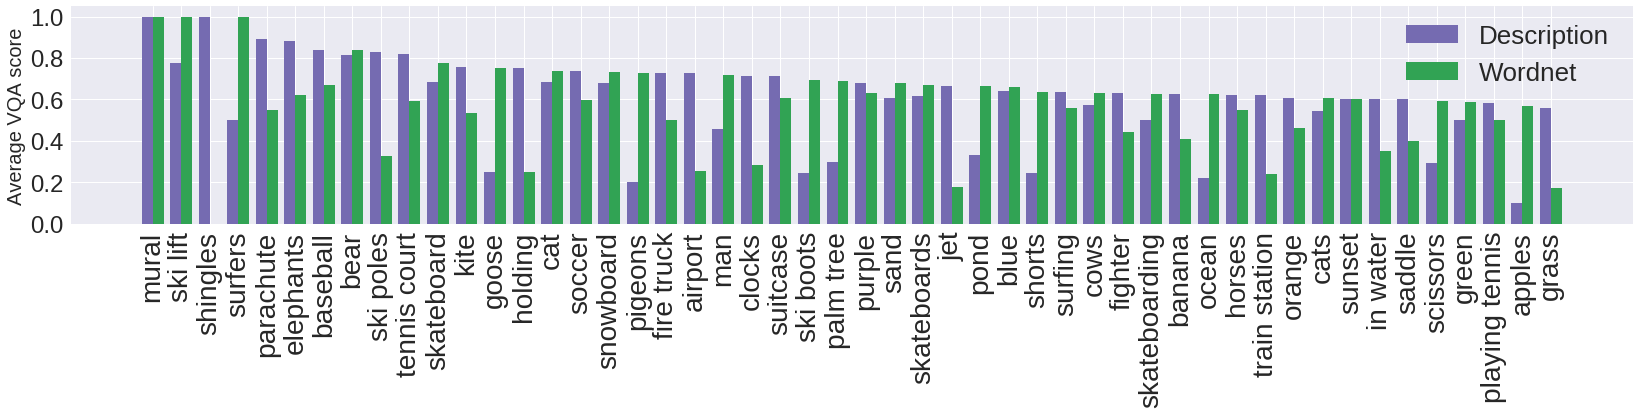

In [369]:
plt.figure(figsize=(28, 4))
i = 0
j = i + 50
i_ans = list(ans)[i:j]
range_ans = np.array(list(range(len(i_ans))))
bar_width = 0.5
plt.bar(range_ans *1.3, list(s1)[i:j], bar_width, tick_label=i_ans, color='#756bb1')
plt.bar(range_ans*1.3+bar_width, list(s2)[i:j], bar_width, tick_label=i_ans, color='#31a354')
plt.xticks(range_ans*1.3 + bar_width * 0.5, i_ans, rotation='vertical', fontsize=28)
plt.yticks(fontsize=24)
plt.ylabel('Average VQA score', fontsize=20)
plt.legend(['Description', 'Wordnet'], fontsize=26, bbox_to_anchor=(0.84, 0.53))
plt.savefig('plots/score_per_answer.png', bbox_inches='tight')
plt.show()

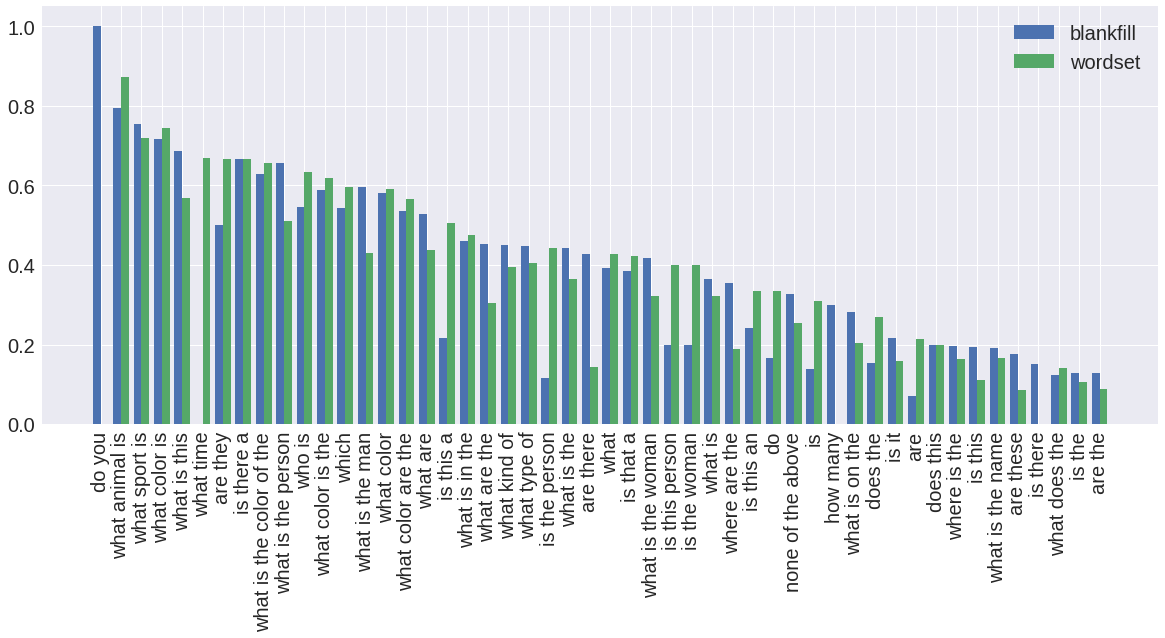

In [271]:
plt.figure(figsize=(20, 10))
i = 0
j = i + 50
i_qtype = list(qtypes)[i:j]
range_qtype = np.array(list(range(len(i_qtype))))
bar_width = 0.5
plt.bar(range_qtype *1.3, list(qtype_s1)[i:j], bar_width, tick_label=i_qtype)
plt.bar(range_qtype*1.3+bar_width, list(qtype_s2)[i:j], bar_width, tick_label=i_qtype)
plt.xticks(range_qtype*1.3 + (bar_width *0.5), i_qtype, rotation='vertical', fontsize=20)
plt.yticks(fontsize=20)
plt.legend(['blankfill', 'wordset'], fontsize=20)
plt.subplots_adjust(bottom=0.3)
plt.savefig('temp_plot.png')
plt.show()

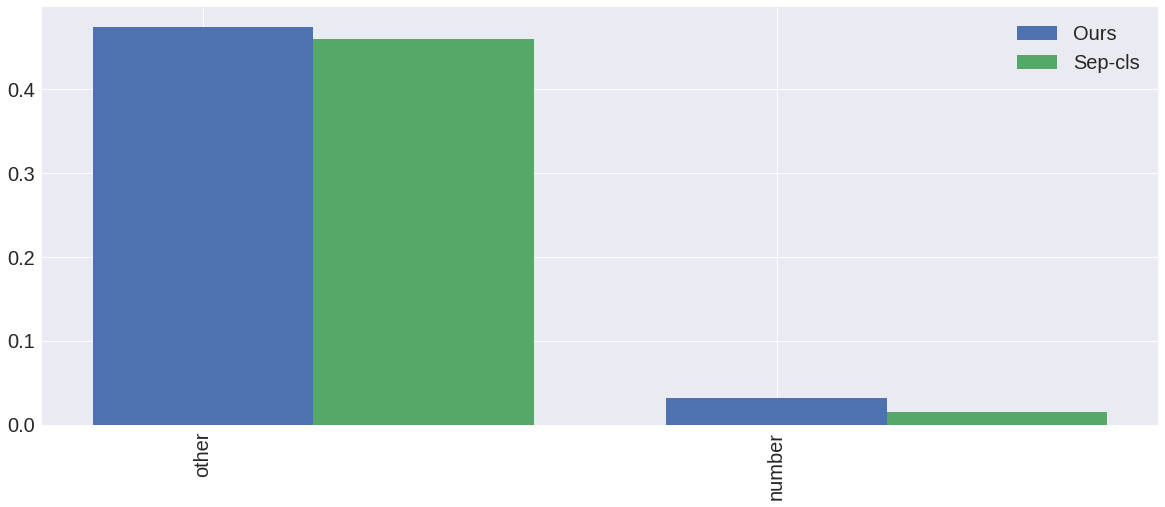

In [267]:
plt.figure(figsize=(20, 10))
i = 0
j = i + 50
i_atype = list(atypes)[i:j]
range_atype = np.array(list(range(len(i_atype))))
bar_width = 0.5
plt.bar(range_atype *1.3, list(atype_s1)[i:j], bar_width, tick_label=i_atype)
plt.bar(range_atype*1.3+bar_width, list(atype_s2)[i:j], bar_width, tick_label=i_atype)
plt.xticks(range_atype*1.3, i_atype, rotation='vertical', fontsize=20)
plt.yticks(fontsize=20)
plt.legend(['Ours', 'Sep-cls'], fontsize=20)
plt.subplots_adjust(bottom=0.3)
plt.savefig('temp_plot.png')
plt.show()

In [27]:
ans1, score1 = zip(*sorted(ans2avg_score1.items(), key=lambda x: x[1], reverse=True))

In [28]:
ans2, score2 = zip(*sorted(ans2avg_score2.items(), key=lambda x: x[1], reverse=True))

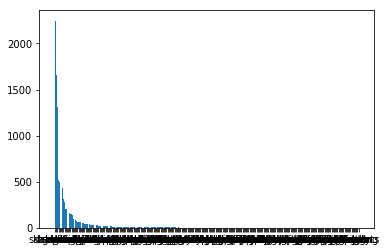

In [29]:
plt.bar(list(range(len(ans1))), list(score1), tick_label=list(ans1))
plt.show()

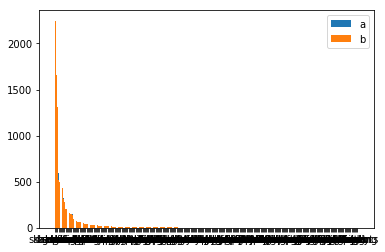

In [30]:
plt.bar(list(range(len(ans2))), list(score2), tick_label=list(ans2))
plt.bar(list(range(len(ans1))), list(score1), tick_label=list(ans1))
plt.legend(['a', 'b'])
plt.show()

In [31]:
plt.bar(list(range(len([ans2avg_score1])

SyntaxError: unexpected EOF while parsing (<ipython-input-31-a3d650cc261c>, line 1)

In [ ]:
plt.bar([1,2,3], [2,3,4], tick_label=['a','b','c'])
plt.bar([1,2,3], [2,3,4], tick_label=['a','b','c'])
plt.show()

In [113]:
len(test_answers)

391

In [102]:
questions = [qid2res1[qid]['question'] for qid in pure_test_qids]
print(len(questions))
question_set = set(questions)
print(len(question_set))
question_count = dict(Counter(questions))
total_q = float(sum(question_count.values()))
question_prob = {q: cnt / total_q for q, cnt in question_count.items()}
print(sum(question_prob.values()))
print(question_prob.items()[:3])

20802
10760
1.0
[(u"what color is this man 's shirt ?", 0.00028843380444188056), (u'what color is on the back wall ?', 4.8072300740313434e-05), (u'what is this made of ?', 4.8072300740313434e-05)]


In [103]:
images = [qid2res1[qid]['image_id'] for qid in pure_test_qids]
print(len(images))
image_set = set(images)
print(len(image_set))
image_count = dict(Counter(images))
total_image = float(sum(image_count.values()))
image_prob = {i: cnt / total_image for i, cnt in image_count.items()}
print(image_prob.items()[:3])

20802
18081
[('val2014-COCO_val2014_000000471625.jpg', 4.8072300740313434e-05), ('train2014-COCO_train2014_000000098746.jpg', 4.8072300740313434e-05), ('train2014-COCO_train2014_000000240568.jpg', 4.8072300740313434e-05)]


In [104]:
preds1 = [qid2res1[qid]['pred'] for qid in pure_test_qids]
preds2 = [qid2res2[qid]['pred'] for qid in pure_test_qids]
print(len(preds1), len(preds2))
pred_set1 = set(preds1)
pred_set2 = set(preds2)
pred_total_set = pred_set1 | pred_set2
print(len(pred_set1), len(pred_set2), len(pred_total_set))
pred_count1 = dict(Counter(preds1))
pred_count2 = dict(Counter(preds2))
eps = 1e-7
for v in list(pred_total_set):
    if v in pred_count1:
        pred_count1[v] += eps
    else:
        pred_count1[v] = eps
    if v in pred_count2:
        pred_count2[v] += eps
    else:
        pred_count2[v] = eps
total_pred1 = float(sum(pred_count1.values()))
pred_prob1 = {p: cnt / total_pred1 for p, cnt in pred_count1.items()}
print(sum(pred_prob1.values()))
print(pred_prob1.items()[:3])
total_pred2 = float(sum(pred_count2.values()))
pred_prob2 = {p: cnt / total_pred2 for p, cnt in pred_count2.items()}
print(sum(pred_prob2.values()))
print(pred_prob2.items()[:3])

(20802, 20802)
(1068, 1055, 1309)
1.0
[(u'shop', 0.0001922892065584671), (u'swirls', 4.807230043780926e-12), (u'coach', 4.807230524503931e-05)]
1.0
[(u'shop', 4.807230043780956e-12), (u'swirls', 4.807230524503961e-05), (u'coach', 4.807230043780956e-12)]


In [23]:
eps = 1e-7

In [105]:
triples1 = [qid2res1[qid]['question'] + '***' + qid2res1[qid]['pred'] + '***' + qid2res1[qid]['image_id']
           for qid in pure_test_qids]
triples2 = [qid2res2[qid]['question'] + '***' + qid2res2[qid]['pred'] + '***' + qid2res2[qid]['image_id']
           for qid in pure_test_qids]
print(len(triples1), len(triples2))
triple_set1 = set(triples1)
triple_set2 = set(triples2)
triple_total_set = triple_set1 | triple_set2
print(len(triple_set1), len(triple_set2), len(triple_total_set))
triple_count1 = dict(Counter(triples1))
triple_count2 = dict(Counter(triples2))
for v in list(triple_total_set):
    if v in triple_count1:
        triple_count1[v] += eps
    else:
        triple_count1[v] = eps
    if v in triple_count2:
        triple_count2[v] += eps
    else:
        triple_count2[v] = eps
total_triple1 = float(sum(triple_count1.values()))
triple_prob1 = {q: cnt / total_triple1 for q, cnt in triple_count1.items()}
print(sum(triple_prob1.values()))
print(triple_prob1.items()[:5])
total_triple2 = float(sum(triple_count2.values()))
triple_prob2 = {q: cnt / total_triple2 for q, cnt in triple_count2.items()}
print(sum(triple_prob2.values()))
print(triple_prob2.items()[:5])

(20802, 20802)
(20792, 20793, 30740)
0.999999999999
[(u'what kind of meat is being prepared here ?***construction***val2014-COCO_val2014_000000533452.jpg', 4.807229844366557e-05), (u'sunny or overcast ?***overcast***train2014-COCO_train2014_000000115356.jpg', 4.807229844366557e-05), (u'what animal is this ?***cat***train2014-COCO_train2014_000000186442.jpg', 4.807229844366557e-05), (u'what is flying under the clouds ?***kite***train2014-COCO_train2014_000000018748.jpg', 4.807229844366557e-05), (u'what color is the water ?***brown***train2014-COCO_train2014_000000118162.jpg', 4.80722936364362e-12)]
0.999999999999
[(u'what kind of meat is being prepared here ?***construction***val2014-COCO_val2014_000000533452.jpg', 4.807229363643626e-12), (u'sunny or overcast ?***overcast***train2014-COCO_train2014_000000115356.jpg', 4.807229844366563e-05), (u'what animal is this ?***cat***train2014-COCO_train2014_000000186442.jpg', 4.807229844366563e-05), (u'what color is the water ?***brown***train201

In [106]:
triple_prob = triple_prob1
pred_prob = pred_prob1
toc = 0
for triple in tqdm(triple_prob):
    tri_p = triple_prob[triple]
    q, a, i = triple.split('***')
    q_p = question_prob[q]
    a_p = pred_prob[a]
    i_p = image_prob[i]
    toc += tri_p * math.log(tri_p / (q_p * a_p * i_p))
print(toc)

100%|██████████| 30740/30740 [00:00<00:00, 193350.54it/s]

12.996268387


In [107]:
triple_prob = triple_prob2
pred_prob = pred_prob2
toc = 0
for triple in tqdm(triple_prob):
    tri_p = triple_prob[triple]
    q, a, i = triple.split('***')
    q_p = question_prob[q]
    a_p = pred_prob[a]
    i_p = image_prob[i]
    toc += tri_p * math.log(tri_p / (q_p * a_p * i_p))
print(toc)

100%|██████████| 30740/30740 [00:00<00:00, 147917.19it/s]

13.1041743419


In [108]:
tuples1 = [qid2res1[qid]['question'] + '***' + qid2res1[qid]['pred']
          for qid in pure_test_qids]
tuples2 = [qid2res2[qid]['question'] + '***' + qid2res2[qid]['pred']
          for qid in pure_test_qids]
print(len(tuples1), len(tuples2))
tuple_set1 = set(tuples1)
tuple_set2 = set(tuples2)
tuple_total_set = tuple_set1 | tuple_set2
print(len(tuple_set1), len(tuple_set2), len(tuple_total_set))
tuple_count1 = dict(Counter(tuples1))
tuple_count2 = dict(Counter(tuples2))
for v in list(tuple_total_set):
    if v in tuple_count1:
        tuple_count1[v] += eps
    else:
        tuple_count1[v] = eps
    if v in tuple_count2:
        tuple_count2[v] += eps
    else:
        tuple_count2[v] = eps
total_tuple1 = float(sum(tuple_count1.values()))
tuple_prob1 = {q: cnt / total_tuple1 for q, cnt in tuple_count1.items()}
print(sum(tuple_prob1.values()))
print(tuple_prob1.items()[:5])
total_tuple2 = float(sum(tuple_count2.values()))
tuple_prob2 = {q: cnt / total_tuple2 for q, cnt in tuple_count2.items()}
print(sum(tuple_prob2.values()))
print(tuple_prob2.items()[:5])

(20802, 20802)
(13518, 13762, 20859)
1.0
[(u'who is the man with the gray pants ?***umpire', 4.807230072712031e-05), (u'is this design more modern or traditional ?***chinese', 4.807230072712031e-05), (u'what is under the plate ?***table', 4.807230072712031e-05), (u'who is riding the elephant ?***elephant', 4.807229591989072e-12), (u'what is the game called ?***skateboard', 4.807230072712031e-05)]
1.0
[(u'who is the man with the gray pants ?***umpire', 4.807230072712168e-05), (u'is this design more modern or traditional ?***chinese', 4.807229591989208e-12), (u'what is under the plate ?***table', 4.807229591989208e-12), (u'who is riding the elephant ?***elephant', 4.807230072712168e-05), (u'what is the game called ?***skateboard', 4.807230072712168e-05)]


In [109]:
tuple_prob = tuple_prob1
pred_prob = pred_prob1
toc = 0
for tup in tqdm(tuple_prob):
    bi_p = tuple_prob[tup]
    q, a = tup.split('***')
    q_p = question_prob[q]
    a_p = pred_prob[a]
    toc += bi_p * math.log(bi_p / (q_p * a_p))
print(toc)

100%|██████████| 20859/20859 [00:00<00:00, 195277.89it/s]

4.33528044529


In [110]:
tuple_prob = tuple_prob2
pred_prob = pred_prob2
toc = 0
for tup in tqdm(tuple_prob):
    bi_p = tuple_prob[tup]
    q, a = tup.split('***')
    q_p = question_prob[q]
    a_p = pred_prob[a]
    toc += bi_p * math.log(bi_p / (q_p * a_p))
print(toc)

100%|██████████| 20859/20859 [00:00<00:00, 198846.29it/s]

4.38598184473


In [ ]:
triples1 = [qid2res1[qid]['question'] + '***' + qid2res1[qid]['pred'] + '***' + qid2res1[qid]['image_id']
           for qid in pure_test_qids]
triples2 = [qid2res2[qid]['question'] + '***' + qid2res2[qid]['pred'] + '***' + qid2res2[qid]['image_id']
           for qid in pure_test_qids]
print(len(triples1), len(triples2))
triple_set1 = set(triples1)
triple_set2 = set(triples2)
triple_total_set = triple_set1 | triple_set2
print(len(triple_set1), len(triple_set2), len(triple_total_set))
triple_count1 = dict(Counter(triples1))
triple_count2 = dict(Counter(triples2))
for v in list(triple_total_set):
    if v in triple_count1:
        triple_count1[v] += eps
    else:
        triple_count1[v] = eps
    if v in triple_count2:
        triple_count2[v] += eps
    else:
        triple_count2[v] = eps
total_triple1 = float(sum(triple_count1.values()))
triple_prob1 = {q: cnt / total_triple1 for q, cnt in triple_count1.items()}
print(sum(triple_prob1.values()))
print(triple_prob1.items()[:5])
total_triple2 = float(sum(triple_count2.values()))
triple_prob2 = {q: cnt / total_triple2 for q, cnt in triple_count2.items()}
print(sum(triple_prob2.values()))
print(triple_prob2.items()[:5])

In [90]:
# ws + bf
q_embed_dir1 = 'experiments/important/0424_main_contribution_exp_answer_zs_3div4/vqa_vlmap_answer_d_qa_split_objattr_answer_3div4_genome_memft_check_all_answer_thres1_50000_thres2_-1_tf_record_memft_vfeat_bottomup_36_my_bf_or_wordset_sp_bs512_lr0.001_20180423-205117/model-4001_eval_train_dump_heavy_20180510-142256'
# noc ws + bf
q_embed_dir2 = 'experiments/important/0424_main_contribution_exp_answer_zs_3div4/vqa_vlmap_answer_noc_d_qa_split_objattr_answer_3div4_genome_memft_check_all_answer_thres1_50000_thres2_-1_tf_record_memft_vfeat_bottomup_36_my_noc_bf_or_wordset_4801_bs512_lr0.001_20180424-171148/model-2401_eval_train_dump_heavy_20180510-143431'

In [91]:
questions = [qid2res1[qid]['question'] for qid in qid2res1]
print(len(questions))
question_set = set(questions)
print(len(question_set))
question_count = dict(Counter(questions))
total_q = float(sum(question_count.values()))
question_prob = {q: cnt / total_q for q, cnt in question_count.items()}
print(sum(question_prob.values()))
print(question_prob.items()[:3])

431853
170535
1.0
[(u'how many people are looking at the motorcycle ?', 4.631205525954434e-06), (u'what does the name in the lower right hand corner signify ?', 2.315602762977217e-06), (u'is the woman wearing earrings ?', 4.3996452496567116e-05)]


In [92]:
images = [qid2res1[qid]['image_id'] for qid in qid2res1]
print(len(images))
image_set = set(images)
print(len(image_set))
image_count = dict(Counter(images))
total_image = float(sum(image_count.values()))
image_prob = {i: cnt / total_image for i, cnt in image_count.items()}
print(image_prob.items()[:3])

431853
120266
[('train2014-COCO_train2014_000000167169.jpg', 4.631205525954434e-06), ('train2014-COCO_train2014_000000291557.jpg', 6.94680828893165e-06), ('train2014-COCO_train2014_000000219177.jpg', 4.631205525954434e-06)]


In [93]:
preds1 = [qid2res1[qid]['pred'] for qid in qid2res1]
preds2 = [qid2res2[qid]['pred'] for qid in qid2res2]
print(len(preds1), len(preds2))
pred_set1 = set(preds1)
pred_set2 = set(preds2)
pred_total_set = pred_set1 | pred_set2
print(len(pred_set1), len(pred_set2), len(pred_total_set))
pred_count1 = dict(Counter(preds1))
pred_count2 = dict(Counter(preds2))
eps = 1e-7
for v in list(pred_total_set):
    if v in pred_count1:
        pred_count1[v] += eps
    else:
        pred_count1[v] = eps
    if v in pred_count2:
        pred_count2[v] += eps
    else:
        pred_count2[v] = eps
total_pred1 = float(sum(pred_count1.values()))
pred_prob1 = {p: cnt / total_pred1 for p, cnt in pred_count1.items()}
print(sum(pred_prob1.values()))
print(pred_prob1.items()[:3])
total_pred2 = float(sum(pred_count2.values()))
pred_prob2 = {p: cnt / total_pred2 for p, cnt in pred_count2.items()}
print(sum(pred_prob2.values()))
print(pred_prob2.items()[:3])

(431853, 431853)
(1558, 1577, 1631)
1.0
[(u'hats', 0.00015051417976823353), (u'yellow', 0.006122453703231008), (u'woods', 6.946808517868273e-06)]
1.0
[(u'hats', 0.00012272694662300153), (u'yellow', 0.008623304686301885), (u'woods', 9.030850795356422e-05)]


In [95]:
eps=1e-7
triples1 = [qid2res1[qid]['question'] + '***' + qid2res1[qid]['pred'] + '***' + qid2res1[qid]['image_id']
           for qid in qid2res1]
triples2 = [qid2res2[qid]['question'] + '***' + qid2res2[qid]['pred'] + '***' + qid2res2[qid]['image_id']
           for qid in qid2res2]
print(len(triples1), len(triples2))
triple_set1 = set(triples1)
triple_set2 = set(triples2)
triple_total_set = triple_set1 | triple_set2
print(len(triple_set1), len(triple_set2), len(triple_total_set))
triple_count1 = dict(Counter(triples1))
triple_count2 = dict(Counter(triples2))
for v in list(triple_total_set):
    if v in triple_count1:
        triple_count1[v] += eps
    else:
        triple_count1[v] = eps
    if v in triple_count2:
        triple_count2[v] += eps
    else:
        triple_count2[v] = eps
total_triple1 = float(sum(triple_count1.values()))
triple_prob1 = {q: cnt / total_triple1 for q, cnt in triple_count1.items()}
print(sum(triple_prob1.values()))
print(triple_prob1.items()[:5])
total_triple2 = float(sum(triple_count2.values()))
triple_prob2 = {q: cnt / total_triple2 for q, cnt in triple_count2.items()}
print(sum(triple_prob2.values()))
print(triple_prob2.items()[:5])

(431853, 431853)
(431794, 431804, 741323)
0.999999999997
[(u'is the napkin made of paper ?***string***train2014-COCO_train2014_000000046353.jpg', 2.3156025970359658e-06), (u'is this restroom clean ?***in water***train2014-COCO_train2014_000000095891.jpg', 2.3156025970359658e-06), (u'are the giraffes all facing the same direction ?***brush***train2014-COCO_train2014_000000471056.jpg', 2.3156025970359658e-06), (u'what are these people getting ready to do ?***walk***train2014-COCO_train2014_000000545361.jpg', 2.3156025970359658e-06), (u'which way is the bird looking ?***right***train2014-COCO_train2014_000000521948.jpg', 2.315602365475729e-13)]
0.999999999997
[(u'is the napkin made of paper ?***string***train2014-COCO_train2014_000000046353.jpg', 2.315602365475729e-13), (u'is this restroom clean ?***in water***train2014-COCO_train2014_000000095891.jpg', 2.315602365475729e-13), (u'are the giraffes all facing the same direction ?***brush***train2014-COCO_train2014_000000471056.jpg', 2.31560

In [96]:
triple_prob = triple_prob1
pred_prob = pred_prob1
toc = 0
for triple in tqdm(triple_prob):
    tri_p = triple_prob[triple]
    q, a, i = triple.split('***')
    q_p = question_prob[q]
    a_p = pred_prob[a]
    i_p = image_prob[i]
    toc += tri_p * math.log(tri_p / (q_p * a_p * i_p))
print(toc)

100%|██████████| 741323/741323 [00:02<00:00, 309904.80it/s]

15.0280799887


In [97]:
triple_prob = triple_prob2
pred_prob = pred_prob2
toc = 0
for triple in tqdm(triple_prob):
    tri_p = triple_prob[triple]
    q, a, i = triple.split('***')
    q_p = question_prob[q]
    a_p = pred_prob[a]
    i_p = image_prob[i]
    toc += tri_p * math.log(tri_p / (q_p * a_p * i_p))
print(toc)

100%|██████████| 741323/741323 [00:02<00:00, 306877.46it/s]

15.0115313933


In [99]:
# ws + bf baseline - noc
print(toc)

13.1041750538


In [78]:
# ws + bf ours
print(toc)

12.996269079


In [57]:
a = 1

In [75]:
math.log(2)

0.6931471805599453

1538

In [27]:
len(images)

115121

In [28]:
image_set = set(images)

In [29]:
len(image_set)

67926